# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition:

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [0]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [0]:
# # Import TensorFlow into Colab
# import tensorflow as tf
# print("TF version:", tf.__version__)

In [3]:
# Import TF 2.x
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [4]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (Yes!!)" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.1.0
TF Hub version: 0.7.0
GPU available (Yes!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [5]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     e1d53fa88060cde37192028ee3ca4629  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

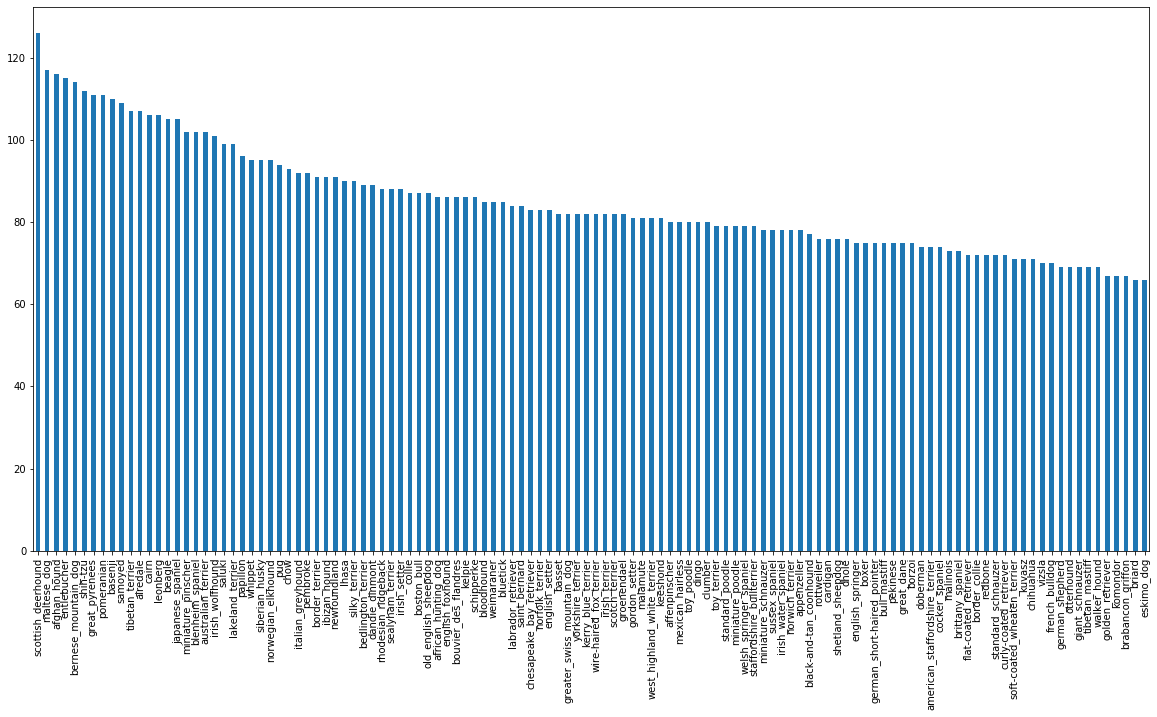

In [7]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [8]:
labels_csv["breed"].value_counts().median()

82.0

Google recommends 10-100+ images per class for model training purposes.

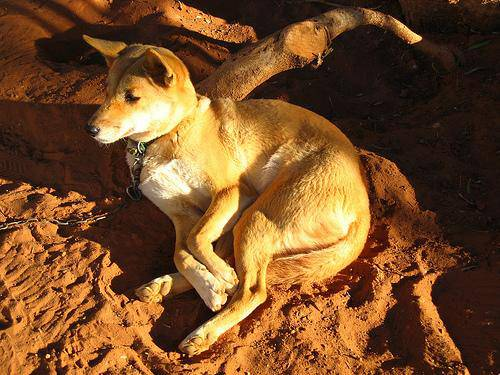

In [9]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our iamge file pathnames.

In [10]:
# Create pathnames from image IDs
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames matches actual number of files! Proceed.")
else:
  print("Filenames does not match actual number of files, check the target directory.")

Filenames matches actual number of files! Proceed.


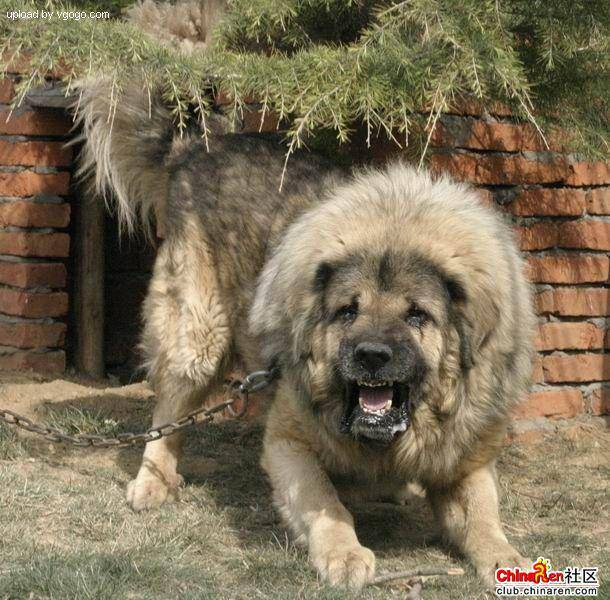

In [12]:
# One more check
Image(filenames[9000])

In [13]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [14]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds
                  for label
                  in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [24]:
filenames[:2]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg']

### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [0]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [26]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [28]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [29]:
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors, we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpeg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`.

Before we do, let's see what importing an image looks like.

In [30]:
# Convert an image to a NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [31]:
image.max(), image.min()

(255, 0)

In [32]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [33]:
# Turn image into a Tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a tensor, let's make a function to preprocess them.

In [0]:
# Defne image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical tensor with 3 color channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Conver the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

32 is usually the default batch size

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [36]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [0]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")  
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  # If the data is a training dataset
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(batch_size)
  
  return data_batch

In [38]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [39]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing data batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [41]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator()) # taken batch off top

In [43]:
len(train_images), len(train_labels)

(32, 32)

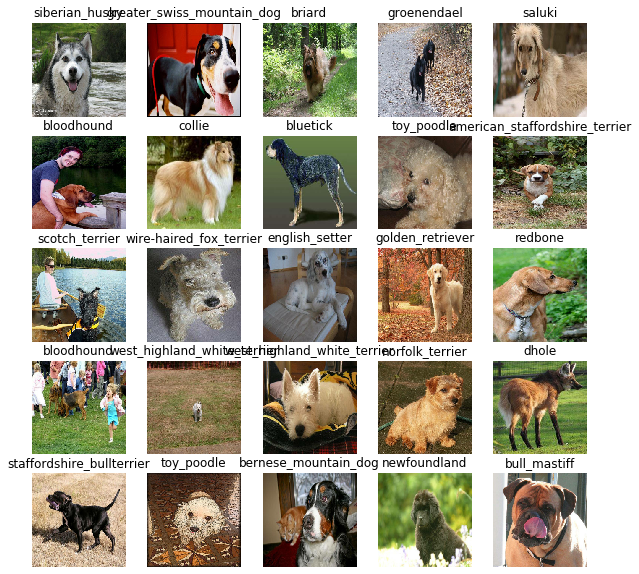

In [44]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

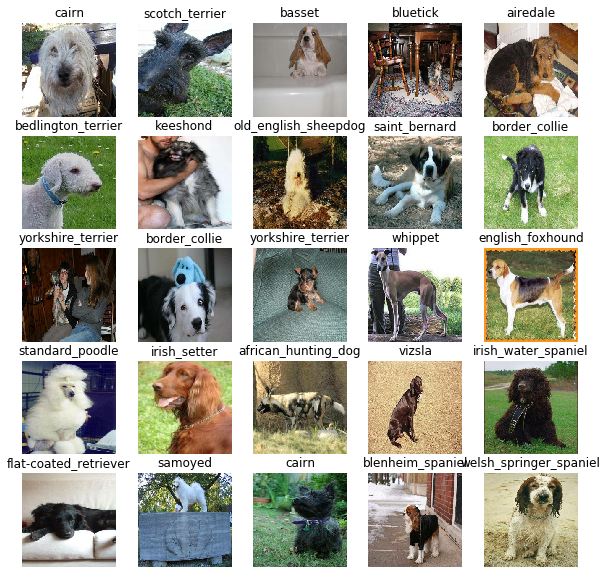

In [45]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs, and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape, and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [0]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(model_url), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units=output_shape,
                                                     activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

In [48]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


Which activation? Which loss?

**Binary classification**
* Activation: Sigmoid
* Loss: Binary Crossentropy

**Multi-class classification**
* Activation: Softmax
* Loss: Categorical Crossentropy

## Creating callbacks

Callbacks are helper functions that a model can use during training to do such things as save its progress, check its progress, or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our model's progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to you model's `fit` function.
3. Visualize our model's training logs with the `%tensorboard` magic function (we'll do this after model training).

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%M%D-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [56]:
# Check to make sure we're still running on a GPU
print("GPU", "available (Yes!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (Yes!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [60]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 454s 18s/step - loss: 4.6332 - accuracy: 0.0938 - val_loss: 3.6610 - val_accuracy: 0.2250
Epoch 2/100
25/25 [==============================] - 6s 220ms/step - loss: 1.6783 - accuracy: 0.6850 - val_loss: 2.2824 - val_accuracy: 0.4700
Epoch 3/100
25/25 [==============================] - 5s 218ms/step - loss: 0.5961 - accuracy: 0.9250 - val_loss: 1.7880 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 6s 222ms/step - loss: 0.2682 - accuracy: 0.9812 - val_loss: 1.5594 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 5s 217ms/step - loss: 0.1561 - accuracy: 0.9950 - val_loss: 1.4733 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 5s 209ms/step - loss: 0.1043 - accuracy: 1.0000 - val_loss: 1.4315 - val_accuracy: 0.6200
Epoch 7/

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [61]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

Output hidden; open in https://colab.research.google.com to view.

## Making and evaluating predictions using a trained model

In [62]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [63]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 2s 216ms/step


array([[1.28505763e-03, 2.60476401e-04, 4.36708564e-03, ...,
        2.25417010e-04, 1.58081370e-04, 8.14852398e-03],
       [1.01313996e-03, 1.39233167e-03, 1.69946365e-02, ...,
        8.91407952e-04, 3.27254902e-03, 2.28049103e-04],
       [4.94855885e-05, 2.77637562e-04, 4.67502905e-05, ...,
        3.43813444e-05, 6.77204880e-05, 2.02224430e-04],
       ...,
       [1.47017345e-05, 1.71668548e-03, 1.66041704e-04, ...,
        1.08043125e-04, 5.06035984e-04, 1.70370884e-04],
       [1.67907251e-03, 3.97321186e-04, 2.27872297e-04, ...,
        7.07740546e-05, 1.27867504e-04, 1.36614162e-02],
       [7.15059054e-04, 7.85391458e-05, 1.03839464e-03, ...,
        2.83863209e-02, 7.08232983e-04, 3.56616889e-04]], dtype=float32)

In [64]:
predictions.shape

(200, 120)

In [65]:
len(y_val)

200

In [66]:
len(unique_breeds)

120

In [67]:
len(predictions)

200

In [68]:
len(predictions[0])

120

In [69]:
predictions[0]

array([1.28505763e-03, 2.60476401e-04, 4.36708564e-03, 2.81814515e-04,
       5.43016999e-04, 5.24305433e-05, 1.96595356e-01, 9.74312890e-04,
       7.52460619e-04, 4.77813417e-04, 6.76139200e-04, 1.48429070e-04,
       1.70880754e-04, 1.06792686e-04, 1.17407111e-03, 3.58686812e-04,
       8.42170411e-05, 1.96991444e-01, 2.86297072e-05, 4.22428042e-04,
       1.95818138e-03, 4.10936133e-04, 2.75341317e-05, 1.62531668e-03,
       2.33367555e-05, 6.41134102e-05, 1.46555781e-01, 1.33008449e-04,
       1.58211694e-03, 3.93436104e-03, 1.37191615e-04, 2.38385997e-04,
       2.09946418e-04, 1.90927618e-04, 6.44482498e-04, 3.02757081e-02,
       3.33001335e-05, 2.05163888e-04, 7.32024637e-05, 4.10151144e-04,
       1.55956729e-03, 8.17484852e-06, 4.94582200e-05, 1.90159422e-04,
       3.13833370e-05, 9.75053117e-05, 6.41647930e-05, 5.34047140e-05,
       7.13804155e-04, 1.22176437e-03, 3.23786429e-04, 2.36327942e-05,
       1.75140725e-04, 1.70111016e-04, 2.08336824e-05, 2.51257388e-05,
      

In [70]:
np.sum(predictions[0])

1.0000001

In [71]:
np.sum(predictions[1])

0.9999999

In [73]:
# First prediction
index = 0
print(predictions[0])
print(f"Max value (probability of predictions): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.28505763e-03 2.60476401e-04 4.36708564e-03 2.81814515e-04
 5.43016999e-04 5.24305433e-05 1.96595356e-01 9.74312890e-04
 7.52460619e-04 4.77813417e-04 6.76139200e-04 1.48429070e-04
 1.70880754e-04 1.06792686e-04 1.17407111e-03 3.58686812e-04
 8.42170411e-05 1.96991444e-01 2.86297072e-05 4.22428042e-04
 1.95818138e-03 4.10936133e-04 2.75341317e-05 1.62531668e-03
 2.33367555e-05 6.41134102e-05 1.46555781e-01 1.33008449e-04
 1.58211694e-03 3.93436104e-03 1.37191615e-04 2.38385997e-04
 2.09946418e-04 1.90927618e-04 6.44482498e-04 3.02757081e-02
 3.33001335e-05 2.05163888e-04 7.32024637e-05 4.10151144e-04
 1.55956729e-03 8.17484852e-06 4.94582200e-05 1.90159422e-04
 3.13833370e-05 9.75053117e-05 6.41647930e-05 5.34047140e-05
 7.13804155e-04 1.22176437e-03 3.23786429e-04 2.36327942e-05
 1.75140725e-04 1.70111016e-04 2.08336824e-05 2.51257388e-05
 1.84775301e-04 6.37960713e-03 1.83919736e-03 2.81555243e-02
 1.50110340e-03 7.15930539e-04 4.48733009e-03 2.36629683e-04
 1.44684163e-03 1.739336